In [83]:
import pandas as pd
import numpy as np

import os
import sys
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
# to play the audio files
from IPython.display import Audio

import tensorflow as tf
tf.random.set_seed(30)

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


DATA PREPARATION

In [84]:
# Paths for data.
Ravdess = "/content/drive/MyDrive/audio_speech_actors_01-24"

In [63]:
import os
import pandas as pd

# Set the Ravdess directory path
Ravdess = '/content/drive/MyDrive/audio_speech_actors_01-24/'

# Check if the directory exists
if not os.path.exists(Ravdess):
    raise FileNotFoundError(f"The directory {Ravdess} does not exist. Please check the path.")

# List the contents of the directory
ravdess_directory_list = os.listdir(Ravdess)
print(f"Contents of Ravdess directory: {ravdess_directory_list}")

file_emotion = []
file_statement = []
file_path = []

for dir in ravdess_directory_list:
    dir_path = os.path.join(Ravdess, dir)
    if not os.path.isdir(dir_path):
        print(f"Skipping non-directory item: {dir_path}")
        continue

    # List the files in the actor directory
    try:
        actor_files = os.listdir(dir_path)
    except FileNotFoundError as e:
        print(f"Error reading directory {dir_path}: {e}")
        continue

    for file in actor_files:
        part = file.split('.')[0].split('-')

        # Check if the filename has the expected number of parts
        if len(part) != 7:
            print(f"Skipping file with unexpected format: {file}")
            continue

        # Extract the emotion and statement from the filename
        try:
            file_emotion.append(int(part[2]))
            file_statement.append(int(part[4]))
            file_path.append(os.path.join(dir_path, file))
        except ValueError as e:
            print(f"Skipping file due to value error: {file}, error: {e}")
            continue

# Create a DataFrame with the extracted information
Ravdess_df = pd.DataFrame({"Emotions": file_emotion, "Statement": file_statement, "Path": file_path})

# Map emotion integers to actual emotion names
emotion_map = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry',
    6: 'fear', 7: 'disgust', 8: 'surprise'
}
Ravdess_df.Emotions.replace(emotion_map, inplace=True)

# Display the DataFrame
print(Ravdess_df.head())


Contents of Ravdess directory: ['Actor_21', 'Actor_13', 'Actor_19', 'Actor_17', 'Actor_14', 'Actor_18', 'Actor_16', 'Actor_20', 'Actor_23', 'Actor_15', 'Actor_08', 'Actor_06', 'Actor_04', 'Actor_09', 'Actor_03', 'Actor_10', 'Actor_05', 'Actor_12', 'Actor_07', 'Actor_11', 'Actor_02', 'Actor_01']
Skipping file with unexpected format: Actor_24
  Emotions  Statement                                               Path
0  neutral          1  /content/drive/MyDrive/audio_speech_actors_01-...
1  neutral          2  /content/drive/MyDrive/audio_speech_actors_01-...
2  neutral          2  /content/drive/MyDrive/audio_speech_actors_01-...
3  neutral          1  /content/drive/MyDrive/audio_speech_actors_01-...
4     calm          2  /content/drive/MyDrive/audio_speech_actors_01-...


In [64]:
Ravdess_df.shape

(1320, 3)

In [65]:
Ravdess_df.groupby(['Emotions','Statement']).size().unstack()

Statement   1   2
Emotions         
angry      88  88
calm       88  88
disgust    88  88
fear       88  88
happy      88  88
neutral    44  44
sad        88  88
surprise   88  88

In [66]:
# creating a copy
data_path = Ravdess_df[['Emotions','Path']].copy()
data_path.to_csv("data_path.csv",index=False)
data_path.head()


Emotions                                               Path
0  neutral  /content/drive/MyDrive/audio_speech_actors_01-...
1  neutral  /content/drive/MyDrive/audio_speech_actors_01-...
2  neutral  /content/drive/MyDrive/audio_speech_actors_01-...
3  neutral  /content/drive/MyDrive/audio_speech_actors_01-...
4     calm  /content/drive/MyDrive/audio_speech_actors_01-...

DATA VISUALISATION

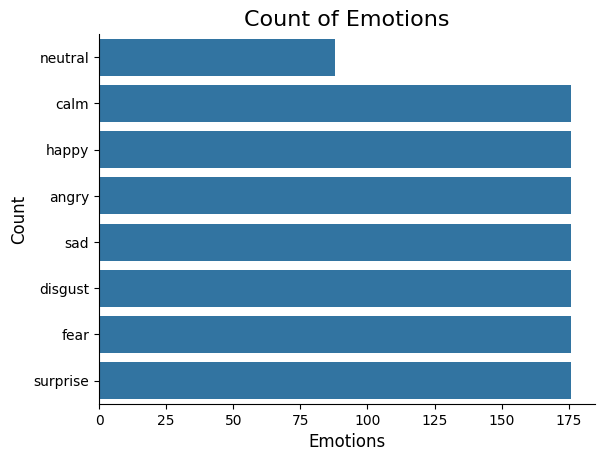

In [67]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [68]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

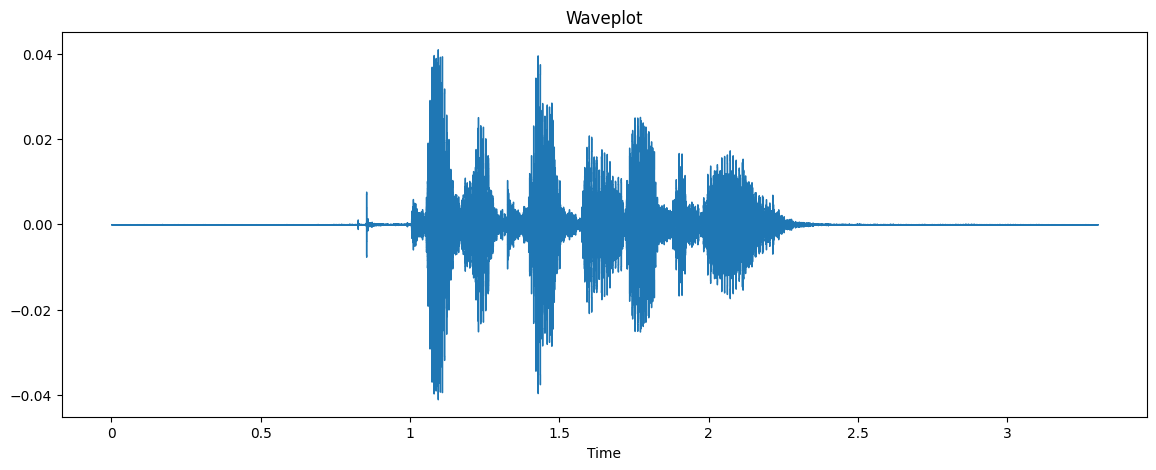

In [69]:
# Define the function to create a waveplot
def create_waveplot(data, sampling_rate):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title("Waveplot")
    plt.show()

# Path to the audio file
path = "/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav"

# Load the audio file
data, sampling_rate = librosa.load(path)

# Create the waveplot
create_waveplot(data, sampling_rate)

# Play the audio
Audio(path)


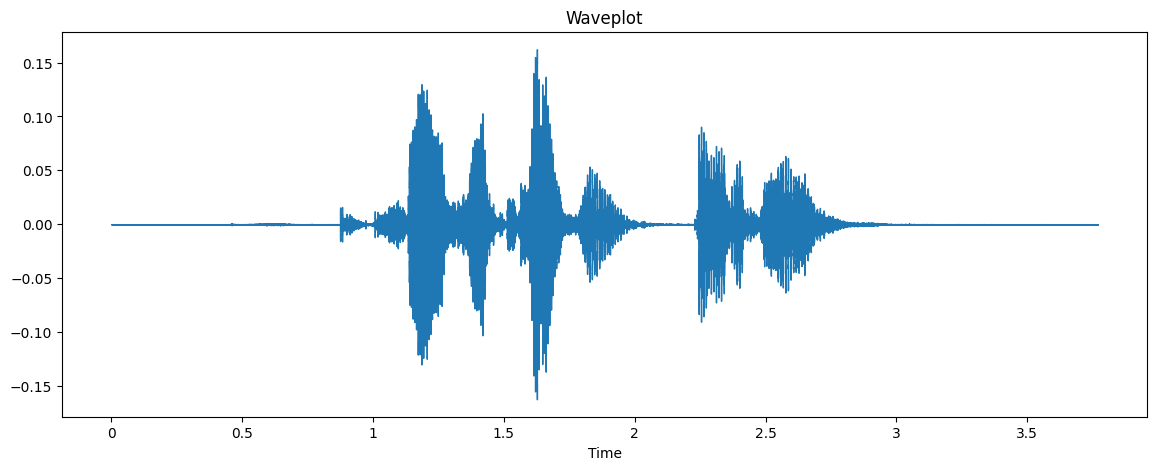

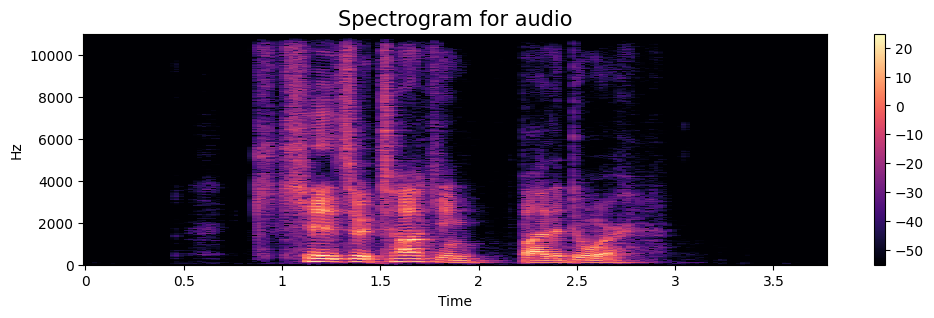

In [70]:
import numpy as np
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

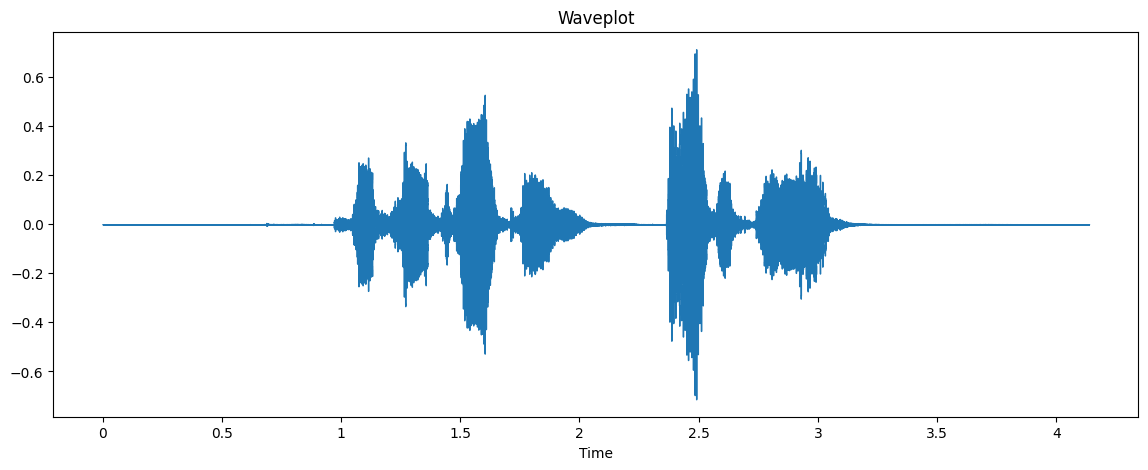

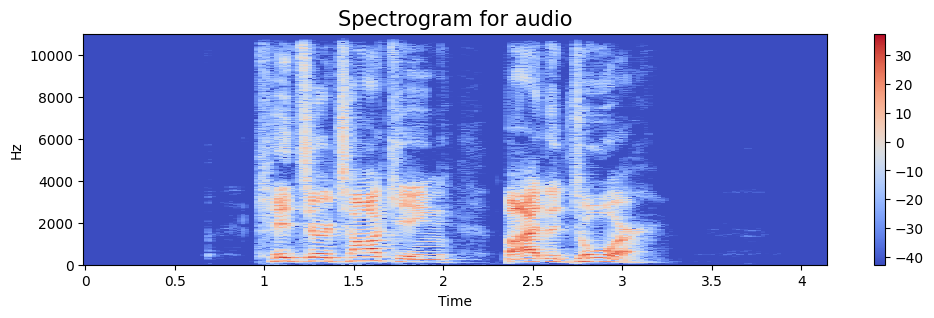

In [71]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

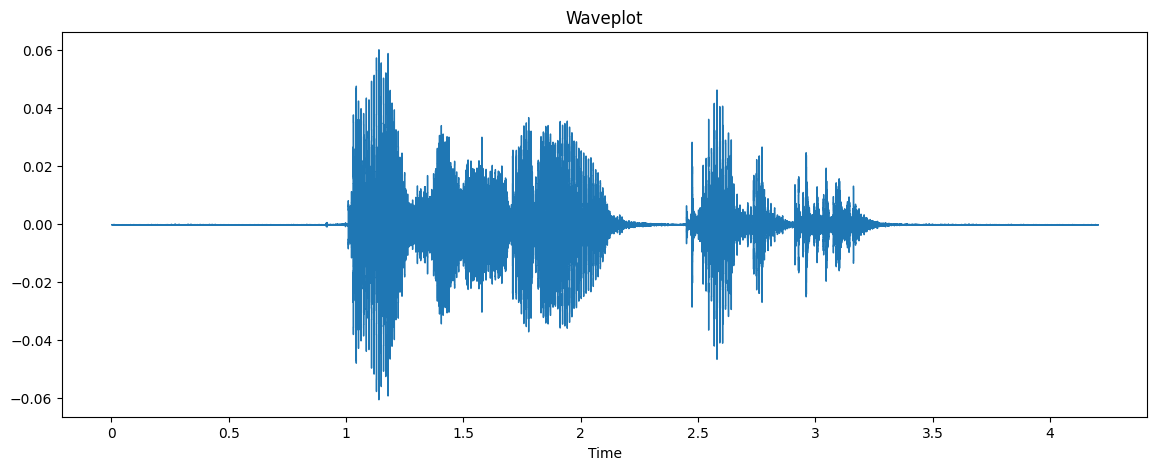

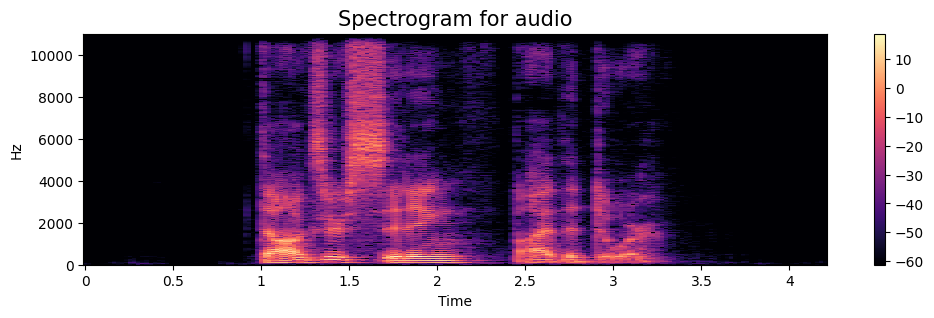

In [72]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)


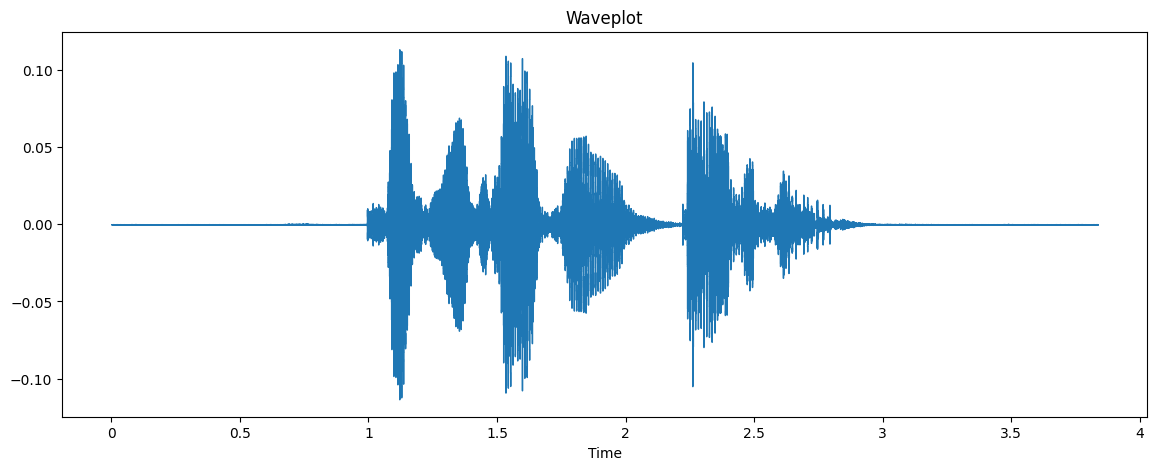

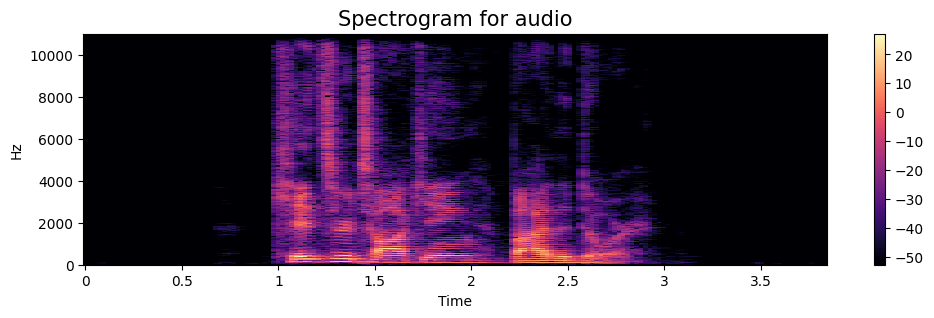

In [73]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

DATA AUGMENTATION

In [74]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

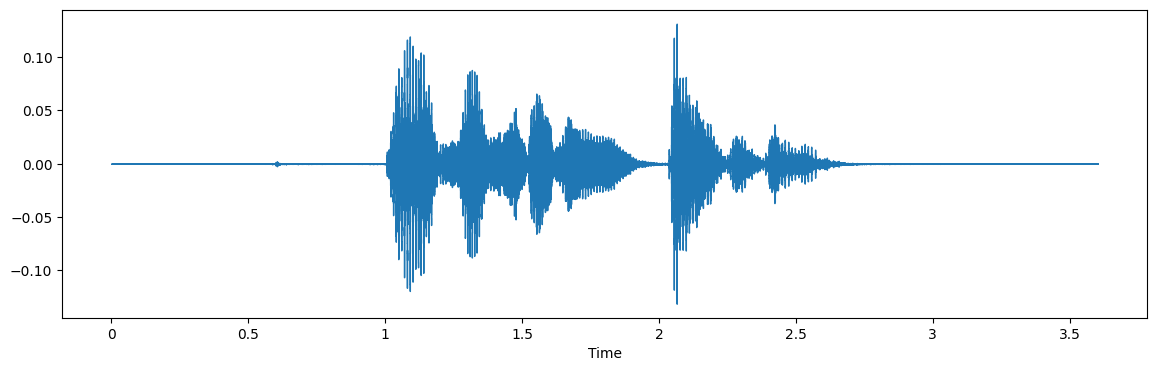

In [75]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

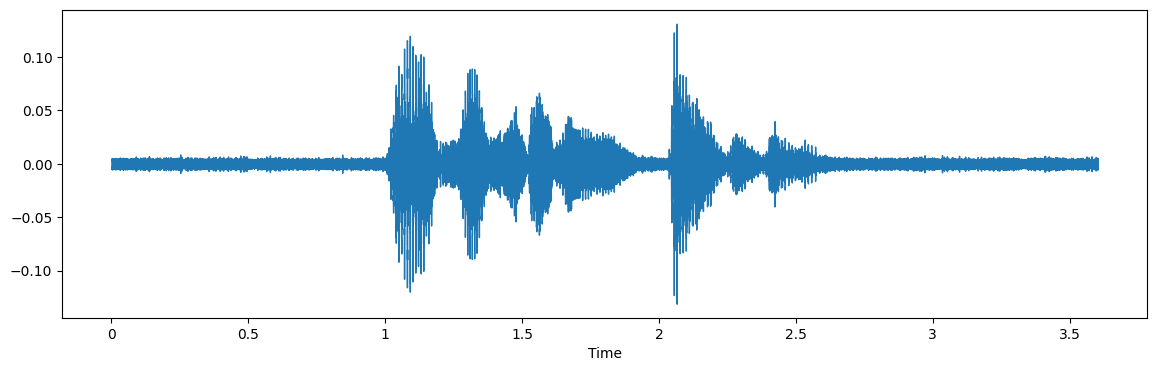

In [76]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

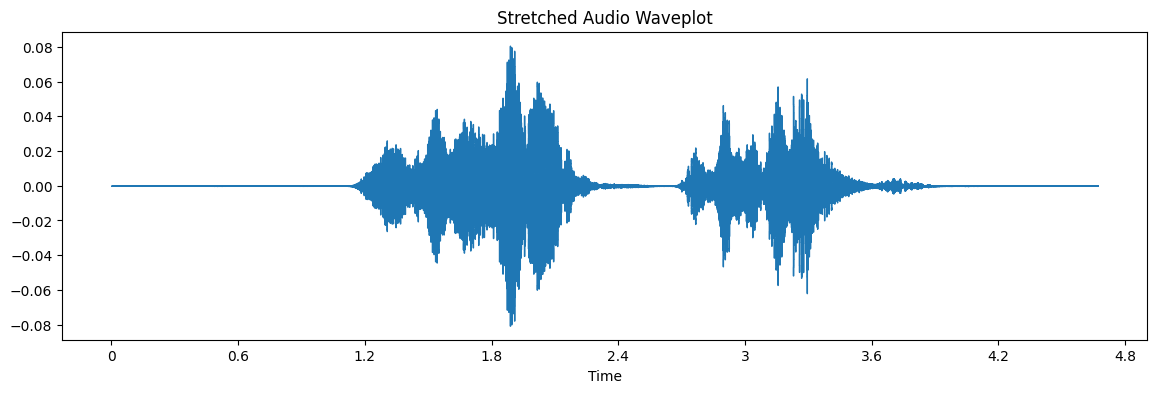

In [77]:
# Define the function to create a waveplot
def create_waveplot(data, sampling_rate):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title("Waveplot")
    plt.show()

# Define the function to create a spectrogram
def create_spectrogram(data, sampling_rate):
    plt.figure(figsize=(14, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    librosa.display.specshow(D, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Spectrogram")
    plt.show()

# Define the stretch function
def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate=rate)

# Load the audio file
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[0]
data, sampling_rate = librosa.load(path)

# Apply the stretch effect
x = stretch(data)

# Create and display the waveplot
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
plt.title("Stretched Audio Waveplot")
plt.show()

# Play the stretched audio
Audio(x, rate=sampling_rate)


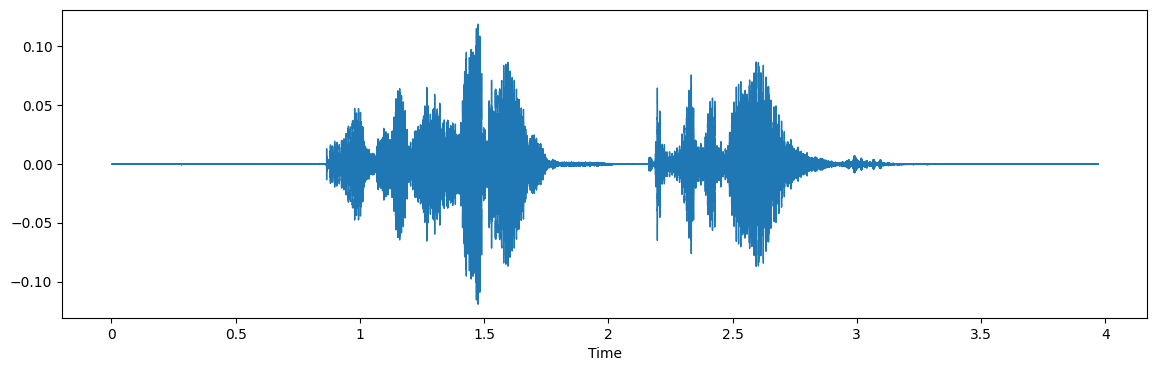

In [78]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

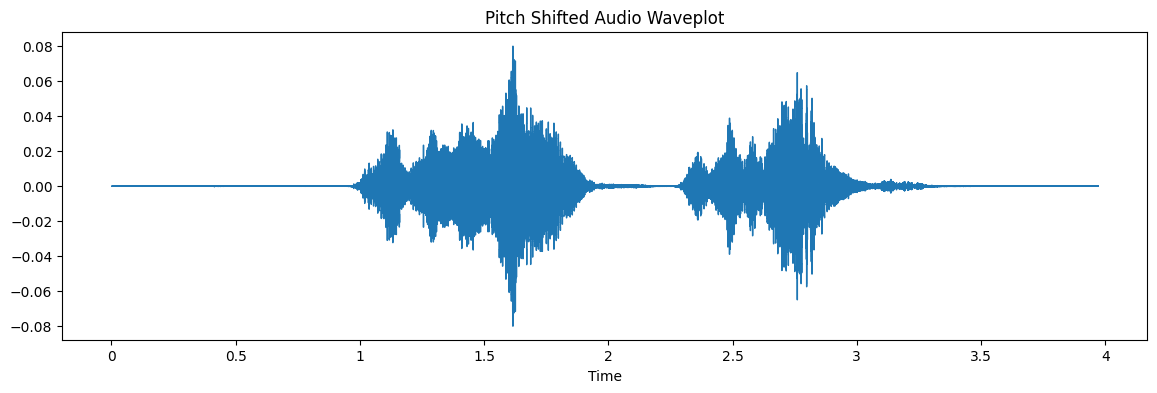

In [79]:
# Define the stretch function
def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate=rate)

# Define the pitch function
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Load the audio file
emotion = 'fear'
path = np.array(data_path.Path[data_path.Emotions == emotion])[0]
data, sampling_rate = librosa.load(path)

# Apply the pitch shift effect
x = pitch(data, sampling_rate)

# Create and display the waveplot
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
plt.title("Pitch Shifted Audio Waveplot")
plt.show()

# Play the pitch-shifted audio
Audio(x, rate=sampling_rate)


FEATURE EXTRACTION

In [80]:
def extract_features(data):
    # MFCC
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate)
    result = mfcc
    return result

# funtion to transform audio
def transform_audio(data, fns):
    fn = random.choice(fns)
    if fn == pitch:
        fn_data = fn(data, sampling_rate)
    elif fn == "None":
        fn_data = data
    elif fn in [noise, stretch]:
        fn_data = fn(data)
    else:
        fn_data = data
    return fn_data


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    #randomly transforming audio data
    fns = [noise, pitch, "None"]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res1 = extract_features(fn2_data)
    result = [np.array(res1[:,:108])]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res2 = extract_features(fn2_data)[:,:108]
    result.append(res2)#np.vstack((result, res2)) # stacking vertically

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res3 = extract_features(fn2_data)[:,:108]
    result.append(res3)#np.vstack((result, res3)) # stacking vertically
    return result

In [81]:
path = "/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
#create_waveplot(data, sampling_rate, emotion)
#create_spectrogram(data, sampling_rate, emotion)
Audio(path)
xx1 = librosa.feature.zero_crossing_rate(data)
stft = np.abs(librosa.stft(data))
xx2 = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
xx3 = librosa.feature.mfcc(y=data, sr=sample_rate)
xx4 = librosa.feature.rms(y=data)
xx5 = librosa.feature.melspectrogram(y=data, sr=sample_rate)
xx1.shape, xx2.shape, xx3.shape, xx4.shape, xx5.shape, np.append(xx1,xx2,axis=0).shape

#xx = extract_features(data)
#fns = [noise, stretch, pitch]
#xx1 = extract_features(stretch(data))
#xx.shape, xx1.shape
#xx = get_features(path)
#len(xx)

((1, 108), (12, 108), (20, 108), (1, 108), (128, 108), (13, 108))

In [82]:
X, Y = [], []
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (20, 108):
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        else:
            print(ele.shape)

(20, 107)
(20, 107)
(20, 107)
(20, 101)
(20, 101)
(20, 101)
(20, 104)
(20, 104)
(20, 104)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 103)
(20, 103)
(20, 103)
(20, 107)
(20, 107)
(20, 107)


In [85]:
len(X), len(Y), data_path.Path.shape

(3915, 3915, (1320,))

In [86]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(20):
    dfm[i] = [k[i] for k in xx]

In [87]:
Features = dfm.copy()
Features['labels'] = Y
#Features.to_csv('features.csv', index=False)
Features.head()

0  \
0  [-587.9683331734865, -557.2304778190803, -560....   
1  [-811.2001, -811.2992, -797.46124, -777.3617, ...   
2  [-811.2001, -811.2992, -797.46124, -777.3617, ...   
3  [-413.9813878249004, -382.07091996625076, -395...   
4  [-460.60569841357113, -433.3669194116612, -429...   

                                                   1  \
0  [0.3918224696914203, -2.4920117177758807, -8.1...   
1  [19.628521, 18.06759, 25.862562, 34.08587, 27....   
2  [19.628521, 18.06759, 25.862562, 34.08587, 27....   
3  [0.5759103876935556, 3.4766900491444868, 0.613...   
4  [3.008740336938102, -1.6004076696330856, -0.77...   

                                                   2  \
0  [9.35470905590174, 1.7185720128200863, -1.0113...   
1  [18.331585, 15.919741, 14.387458, 9.771994, 4....   
2  [18.331585, 15.919741, 14.387458, 9.771994, 4....   
3  [-0.9603464267118208, -1.0600063284455385, -1....   
4  [9.246684024378677, 6.391204269512035, 3.38737...   

                                                   3  \
0  [-0.38780465223128346, -1.2992789276806538, 2....   
1  [16.306522, 14.202408, 14.217077, 14.61382, 13...   
2  [16.306522, 14.202408, 14.217077, 14.61382, 13...   
3  [1.0744899705670519, 5.008600826616794, 4.9879...   
4  [-0.7108732292927135, 3.2863691792608014, 2.24...   

                                                   4  \
0  [-2.3848581180137813, -1.1463110005080188, 0.8...   
1  [13.740545, 10.654496, 10.9737015, 6.0953655, ...   
2  [13.740545, 10.654496, 10.9737015, 6.0953655, ...   
3  [1.5089543562411145, -0.5192944077640198, -2.3...   
4  [-1.103255642645787, 2.4364754597535487, -0.59...   

                                                   5  \
0  [6.663975354745537, 8.408702846265104, 4.08148...   
1  [10.863268, 7.3858156, 5.3280787, 0.4004135, -...   
2  [10.863268, 7.3858156, 5.3280787, 0.4004135, -...   
3  [6.043918108057423, 2.7018853241518164, 1.9474...   
4  [2.969849848504871, 0.26554579368277, -4.79019...   

                                                   6  \
0  [8.251382645958769, 2.6712022541687834, -1.050...   
1  [7.919695, 4.0530643, -1.6818023, -8.332315, -...   
2  [7.919695, 4.0530643, -1.6818023, -8.332315, -...   
3  [-3.405881654838376, -3.07189175610908, -1.490...   
4  [-2.2466819633559663, -2.911392350033477, -2.6...   

                                                   7  \
0  [0.4352361763681155, -3.4335981230620964, -4.0...   
1  [5.1421976, 1.1447223, -5.095977, -12.240641, ...   
2  [5.1421976, 1.1447223, -5.095977, -12.240641, ...   
3  [-2.703097947145674, 0.17421040607289262, 2.04...   
4  [-9.088417691842668, -2.3861268633240416, 1.33...   

                                                   8  \
0  [-0.28556319803442615, 2.0904195319675063, 3.9...   
1  [2.7254505, 0.7520218, 2.297258, 1.8483117, 1....   
2  [2.7254505, 0.7520218, 2.297258, 1.8483117, 1....   
3  [-0.17453203489222568, -0.6937147588085253, -3...   
4  [5.765471380042402, 5.24274773414901, -0.13520...   

                                                   9  ...  \
0  [0.22435612657956747, 6.273332689092589, 5.022...  ...   
1  [0.8072351, -0.22797978, -2.506153, -5.857404,...  ...   
2  [0.8072351, -0.22797978, -2.506153, -5.857404,...  ...   
3  [5.659255276490795, 6.91309279909078, 3.752675...  ...   
4  [0.7881786695393558, 0.9753577394798336, -1.44...  ...   

                                                  11  \
0  [-7.599403901344074, -1.6282951545957667, 2.52...   
1  [-1.322485, 1.2227411, 1.8130666, -2.549343, 2...   
2  [-1.322485, 1.2227411, 1.8130666, -2.549343, 2...   
3  [2.0223565705439657, 7.333561834176597, 8.9803...   
4  [6.222923300205661, 1.3502272047969504, -1.339...   

                                                  12  \
0  [-1.685158376209068, 0.45009585226047033, 1.10...   
1  [-1.5945015, 2.7505474, 5.2884994, 4.807588, 1...   
2  [-1.5945015, 2.7505474, 5.2884994, 4.807588, 1...   
3  [-4.1108586037909145, -2.676081326977668, 1.69...   
4  [7.943796663523781, 2.546939172

In [88]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((3915, 20, 108), (3915,))

DATA PREPARATION


In [89]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [90]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3132, 20, 108), (3132, 8), (783, 20, 108), (783, 8))

In [91]:
# making data compatible to model.
x_train = np.expand_dims(x_train, axis=3)
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.expand_dims(x_train, axis=3)

x_test = np.expand_dims(x_test, axis=3)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.expand_dims(x_test, axis=3)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3132, 108, 20, 1, 1), (3132, 8), (783, 108, 20, 1, 1), (783, 8))

MODELLING

In [92]:
input_shape = x_train.shape[1:]
input_shape #(108, 162, 1, 1)

(108, 20, 1, 1)

In [93]:
model=Sequential()

model.add(TimeDistributed(Conv1D(16, 3, padding='same', activation='relu'),
                            input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D((2,1))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 108, 20, 1, 16)    64        
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 108, 20, 1, 16)    64        
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 108, 320)          0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 32)                45184     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

In [95]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4, min_lr=0.0000001)

epochs = 100
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])


Epoch 1/100
25/25 [==============================] - 27s 673ms/step - loss: 2.0432 - accuracy: 0.1743 - val_loss: 2.0124 - val_accuracy: 0.2312 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 10s 412ms/step - loss: 1.9742 - accuracy: 0.2251 - val_loss: 1.9744 - val_accuracy: 0.2312 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 8s 322ms/step - loss: 1.9107 - accuracy: 0.2618 - val_loss: 1.9032 - val_accuracy: 0.2899 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 10s 386ms/step - loss: 1.8524 - accuracy: 0.2969 - val_loss: 1.8433 - val_accuracy: 0.3040 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 10s 412ms/step - loss: 1.7884 - accuracy: 0.3186 - val_loss: 1.7947 - val_accuracy: 0.3448 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 8s 313ms/step - loss: 1.7310 - accuracy: 0.3442 - val_loss: 1.7095 - val_accuracy: 0.3474 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 10s 410

25/25 [==============================] - 2s 58ms/step - loss: 0.9390 - accuracy: 0.6373
Accuracy of our model on test data :  63.72924447059631 %


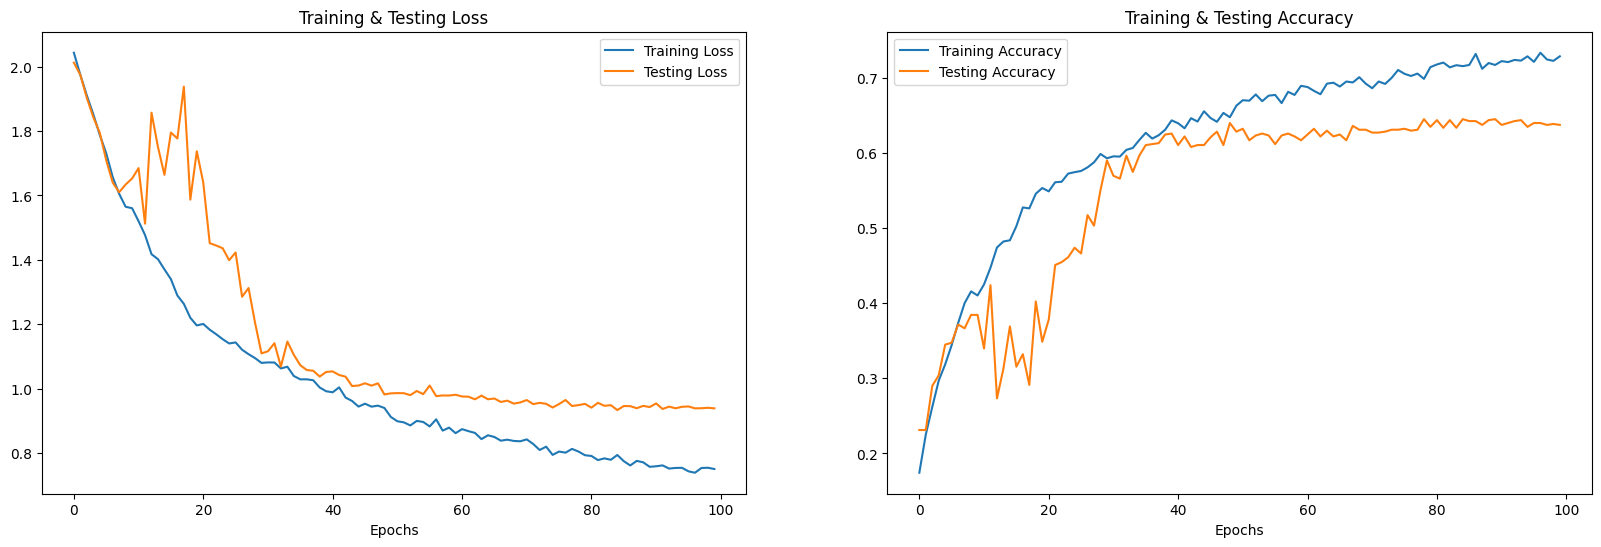

In [96]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [97]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

25/25 [==============================] - 5s 92ms/step


In [98]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear          fear
1          neutral           sad
2             calm       disgust
3             calm           sad
4             calm          calm
5            happy      surprise
6          neutral       neutral
7         surprise         happy
8          disgust           sad
9            angry         angry

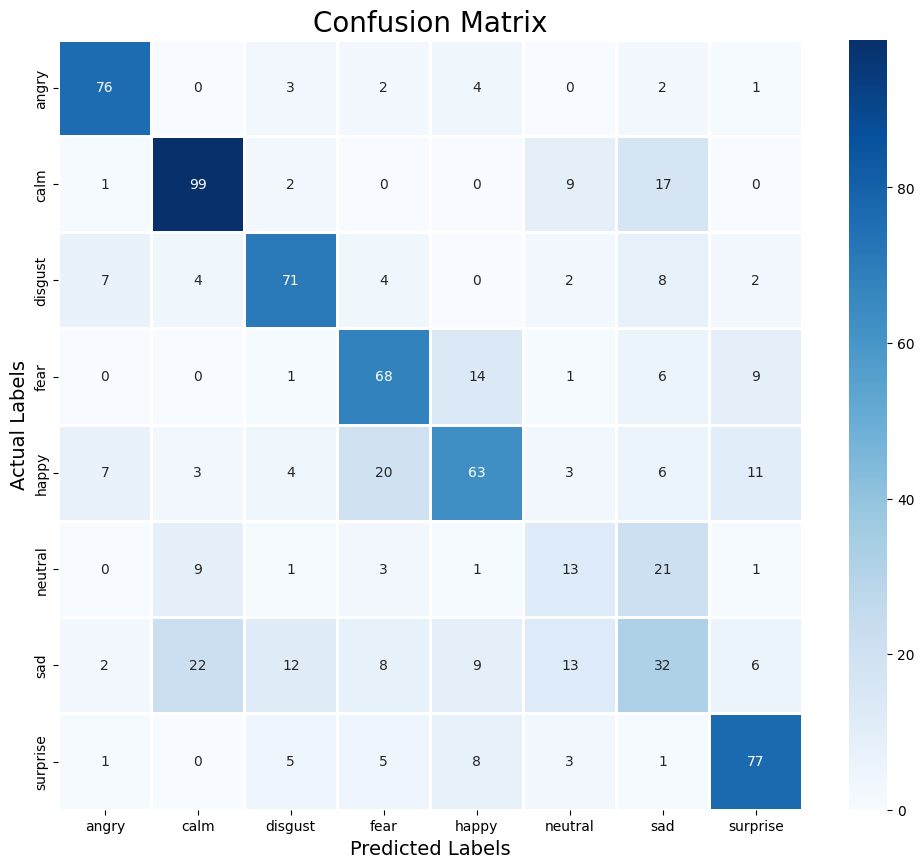

In [99]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [100]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.81      0.86      0.84        88
        calm       0.72      0.77      0.75       128
     disgust       0.72      0.72      0.72        98
        fear       0.62      0.69      0.65        99
       happy       0.64      0.54      0.58       117
     neutral       0.30      0.27      0.28        49
         sad       0.34      0.31      0.32       104
    surprise       0.72      0.77      0.74       100

    accuracy                           0.64       783
   macro avg       0.61      0.62      0.61       783
weighted avg       0.63      0.64      0.63       783

